In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from collections import Counter
from scipy import stats
import numpy as np
import plotly
# set style
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
plt.style.use('seaborn-pastel')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
docs=json.load(open("data/docs.json","rb"))
entities=json.load(open("data/entities_meta.json","rb"))


In [3]:
docs=pd.DataFrame(docs)
print(entities.keys())

dict_keys(['people', 'organizations', 'locations'])


## Goal:
The goal of this project is to create an “overview” of the most important information in our dataset. A reader should be able to get up to speed on the major events that occurred in about 5 minutes or less.
 
## Questions
Part of the fun of being a Product Engineer is that we often have to solve problems with a varied level of initial definition. In general there are 3 broad buckets:
Clearly defined need and feature definition
Clearly defined need by loose product definition
No defined need, but feeling like something more is needed
 
We hope to give you the ability to experience a little bit of each of these in the next three questions


In [4]:
docs.head(2)

,event_id,content,title,date,sources,people,organizations,locations,id,summary
0,4a68a737-a357-47ea-a4b9-afe4f3c1f460,"FLAGSTAFF, Ariz. -- An excavator used to clea...",Spark from wildfire-prevention efforts likely ...,2019-09-13T18:17:35Z,[ABC7NY],"[8e7aff20-4281-5023-8407-f43e5ba289e4, 4fc245e...",[9d4d391e-a27d-4b76-a783-7ce20c9160a0],"[28152159-6443-50c6-864c-f6e9920c9232, 15f3e2e...",7ac25cda-aec2-5af1-a937-4fee15ea35ba,The excavator was working on steep slopes near...
1,3b4e3874-2034-4cc7-9929-09d60f1092e7,“Wildfire raging through the Paradise region i...,Conditions of the California wildfire reflect ...,2018-11-16T12:53:23Z,[ShowMe Plettenberg Bay],"[0aa3184c-c835-5afa-a5e7-656c37a08a7b, 193958f...",[153dc210-6604-4db6-b374-d9167690f2cf],"[dfbf9ad3-9e72-5ba9-99ac-fd32ca480ac1, 2ac73e0...",b04dba07-ffc0-5a49-be3b-6eaaf57150e2,"""Wildfire raging through the Paradise region i..."


In [5]:
# Explore number of missing values
print(docs.isnull().sum())

event_id           0
content            0
title              0
date               0
sources            0
people             0
organizations      0
locations          0
id                 0
summary          107
dtype: int64


## Preprocessing

In [6]:
# Convert date to pd.TimeStamp
docs["date"]=pd.to_datetime(pd.to_datetime(docs["date"]).apply(lambda x: x.date()))

## Code Solution 

In [20]:
from scipy.signal import argrelextrema
import spacy
from src.utils import get_embedding_matrix, closest_to_mean, preprocess_text, documents_to_entities, describe_entities, query_dates
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from itertools import chain
from gensim import corpora
import gensim
import pyLDAvis
from pyLDAvis.gensim import prepare
warnings.filterwarnings("ignore", category=DeprecationWarning)
def query_dates(dates, start, end):
    start_=pd.to_datetime(start)
    end_=pd.to_datetime(end)
    return (dates>=start_)&(dates<=end_)

class Wildfire_News:
    def __init__(self, data, entities):
        """
        input:
            - data: pd.DataFrame, document dataset
            - entities: dict, entities dictionaty with people, organizations and locations as keys
        """
        
        self.data=data.copy()
        locations={x["id"]:x for x in entities["locations"]}
        organizations={x["id"]:x for x in entities["organizations"]}
        people={x["id"]:x for x in entities["people"]}
        self.entities={"locations":(locations, "name"),
                 "organizations":(organizations,"display_organization"),
                 "people":(people,"display_person")}
        self.nlp = spacy.load("en_core_web_sm")
        
        self.preprocessing()
                
    def preprocessing(self):
        # Convert date to pd.TimeStamp
        self.data["date"]=pd.to_datetime(pd.to_datetime(self.data["date"]).apply(lambda x: x.date()))
        
    def document_count(self, freq="d"):
        # count number of documents
        return self.data.groupby(pd.Grouper(key="date", freq=freq)).count()["id"]
    
    def document_count_plot(self, document_count):
        # 
        fig=plt.figure(figsize=(24,8))
        plt.plot(document_count)
        plt.ylabel("Volume of Documents")
        plt.xlabel("Month")
        plt.title("Time-series of document volume for wildfires")
        plt.legend()
        
    def find_peaks(self, document_count,order=180, plot=True):
        """
        inputs:
            - document_count: pd.Series, time series containing document volumes
            - order: int, window size
            - plot: bool, wheater to plot the time series and the peaks
            
        """
        peaks=argrelextrema(document_count.values,comparator=np.greater,order=order)
        peaks=document_count.iloc[peaks]
        if plot:
            self.document_count_plot(document_count)
            plt.scatter(peaks.index, peaks, color="red", marker="*", label="Peaks")
        return peaks
    
    def highlight_title_embedding(self, data):
        """
        input:
            - data: pd.DataFrame, data to extract the event from
        return:
         index in the input data containing the most important title
        """
        # Warning: there should be more data preprocessing, but it serves to illustrate the method
        title_docs=[]
        dic_embedding={}
        # Create embedding vector for all titles in the subset
        peak1=data.drop_duplicates(subset=["title"])
        for sentence in peak1["title"]:
            sent=self.nlp(sentence)
            title_docs.append(sent)
            dic_embedding[sentence]=sent.vector
        embedding_salient=get_embedding_matrix(peak1["title"], dic_embedding)
        # find the vector closest to the center of the documents in subset
        index_max=closest_to_mean(embedding_salient)
        return peak1.index[index_max]

    def highlight_title_tfid(self, data):
        """
        input:
            - data: pd.DataFrame, data to extract the event from
        return:
         index in the input data containing the most important title
        """      
        peak1=data.drop_duplicates(subset=["title"])
        tfid=TfidfVectorizer(stop_words="english")
        
        # calculate tdif based on the entire dataset
        salient=tfid.fit_transform(self.data["title"])
        salient=salient[peak1.index]
        
        # find the vector closest to the center of the documents in subset
        index_max=closest_to_mean(salient.todense())
        return peak1.index[index_max]
    
    def highlight_title_frequency(self, data, cutoff=5):
        """
        input:
            - data: pd.DataFrame, data to extract the event from
        return:
         index in the input data containing the most important title
        """ 
        data=data.drop_duplicates(subset=["title"]).copy()
        # create corpus and term frequency based on the CONTENT
        content_corpus=self.tokenize_corpus(data["content"])
        frequency=Counter(chain(*content_corpus))
        
        # tokenize titles
        titles=self.tokenize_corpus(data["title"])
        
        # create score for every sentence based on the term frequency average
        title_scores=[]
        for title in titles:
            sent_score=0
            if len(title)>cutoff:
                for token in title:
                    if token in set(frequency.keys()):
                        sent_score+=frequency[token]
            title_scores.append(sent_score/len(title))
        return data.index[np.argmax(title_scores)]
    
    def tokenize_corpus(self, data):
        """
        data: pd.Series, containing text to tokenize
        return:
            list of lists containing strings
        """
        processed_data=[]
        for doc in data:
            tokens = preprocess_text(doc)
            processed_data.append(tokens)
        return processed_data
    
    def print_peak(self, index):
        """
        input:
            - index: int, index in the original dataset
        """
        date=self.data["date"].iloc[index].strftime("%Y-%m-%d")
        print(date + "-----> " + self.data.iloc[index]["title"])
        
    def topic_visualization(self, data, n_topics=10):
        """
        input:
            - data: pd.DataFrame
            - n_topics: int, number of topics
        """
        processed_data=self.tokenize_corpus(data["title"])
        gensim_dictionary = corpora.Dictionary(processed_data)
        gensim_corpus = [gensim_dictionary.doc2bow(token, allow_update=True) for token in processed_data]
        lda_model = gensim.models.ldamodel.LdaModel(gensim_corpus, num_topics=n_topics, id2word=gensim_dictionary, passes=15)
        lda_visualization =prepare(lda_model, gensim_corpus, gensim_dictionary, sort_topics=False)
        pyLDAvis.display(lda_visualization)
    
    def date_range_visualization(self, start, end):
        """
        input:
            - start: str, starting date
            - end: str, end date
        """
        
        boolean=query_dates(self.data["date"], start, end)
        subset=self.data.loc[boolean]
        
        # Plot distribution of entities
        describe_entities(self.data, self.entities, subset)
        
        # plot locations
        
        # find latitud and longitude
        w=documents_to_entities(subset["locations"], self.entities["locations"][0], "id", k=500)
        points=[]
        for key, value in w.items():
            lat=self.entities["locations"][0][key]["latitude"]
            long=self.entities["locations"][0][key]["longitude"]
            if np.isnan(lat):
                continue
            points.append([lat,long, value])    
        geo=pd.DataFrame(points, columns=["latitude","longitude","count"])
        
        
        BBox = ((-146.876,  -60.743,      
         16.836, 58.211))

        ruh_m = plt.imread("map.png")
        fig, ax = plt.subplots(figsize = (24,24))
        ax.scatter(geo.longitude, geo.latitude, zorder=1, alpha= 1.0, c='b', s=geo["count"],cmap=plt.get_cmap("jet"),label="Number of documents")
        ax.set_title('Volume of Documents')
        ax.set_xlim(BBox[0],BBox[1])
        ax.set_ylim(BBox[2],BBox[3])
        ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
        plt.legend()

## Question 1)
Given the list documents, create a time-series of document volume for wildfires for the time span of the query.

No handles with labels found to put in legend.


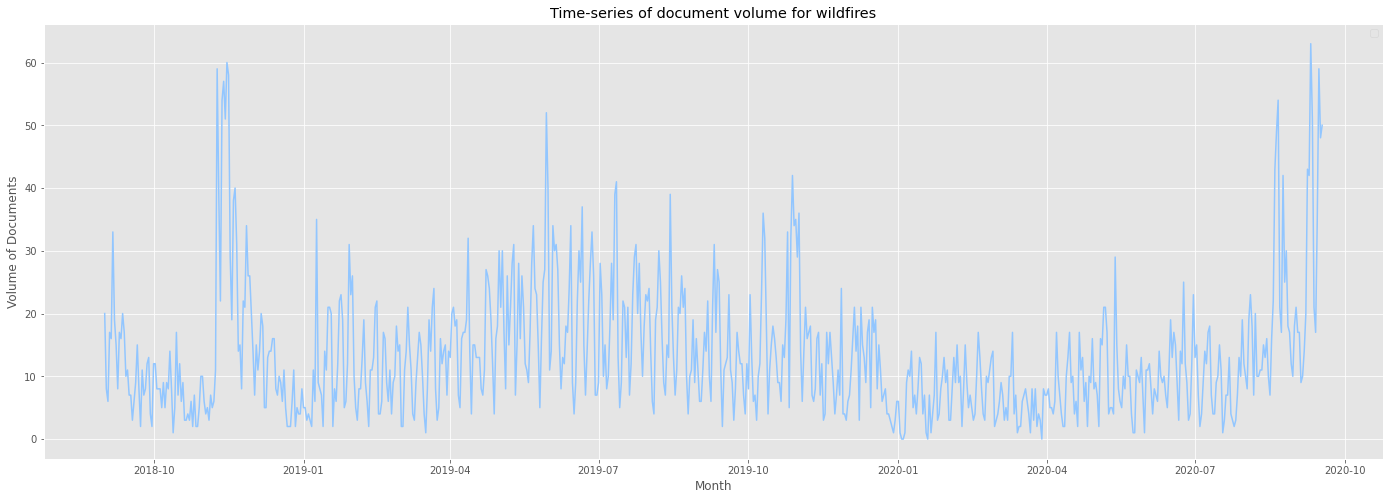

In [21]:
# define class
news_class=Wildfire_News(docs, entities)

# get time series of document_count
document_count=news_class.document_count()
# plot series
news_class.document_count_plot(document_count)

## Question 2)
The time-series from Question 1 shows that there is always some coverage of wildfires, but the volume varies throughout the year, peaking at certain points. We’d like to highlight the important news that happened at those peaks. Develop an algorithm or heuristic to pick the events that happen at the peaks. Remember, the goal of this Overview page is to give someone a 5 minute catch up on the history that led us to today, so we want to limit the amount of information we display to just the most important. Decide how you would like to present the events.
At Primer, we productionize tools to discover insight from data. Make sure your code would be easily understandable to your co-workers.

#### Answer: 

For this question I decided to follow the following approach:
1. First, find the peak dates based on times series analysis. The method to detect peaks is simply based on finding extremely high values related to its neighbors. This can be easily done by just finding the difference between a given observation and the average value of the observations in a rolling window, and then normalizing it. There is one parameter that needs to be set, the size of the window. Whenever the size is smaller, it’s more likely to have more peaks. For this example I used a window size of 180 days. 

2. For a given peak date, find the title that best represents and summarize the articles on that date. The idea behind is that titles usually encansulape concise information about the article. In order to find the titles that best describes the event, I experimented with different approaches:

    a. **Embedding approach**: This is applied on the method **highlight_title_embedding**.  If one sentence is very similar to many others, it will likely be a sentence of great importance. In that sense, the idea is to find a sentence that is closest to the rest. In order to achieve this, it’s necessary to have a representation of the documents that captures semantics and also a measure of similarity between documents. Then, I decided to use the simplest approach: average word embeddings to represent the titles and cosine similarity to measure similarity. After getting a vector representation for every document, I calculated the vector in the center of the group by taking the mean, and chose the document with highest cosine similarity (or closest distance in the vector space) to the center. Here, it’s worth mentioning that I experimented with other approaches. For example, one idea was that there might be titles that do not refer to the event of that date and using them when calculating the mean will affect the interpretation of the center. In order to avoid this, I tried using the DBScan algorithm to just focus on the most common cluster and avoid outliers. However, it didn't seem to make any difference in the results. This might be because the documents in those dates were already too similar. Another idea was to do topic modeling, then the prevalent topic on those dates and choose the sentence that has the highest percentage contribution to that topic, this did not seem to work, maybe further tuning the number of topics was needed. Finally, it’s worth mentioning that I used the most simple approach, and with more time there could be many methods that I would like to try such as train the embeddings using our corpus instead of pretrained embeddings or using doc2vec or other methods for calculating embeddings.
    
    b. **TFID**: Method **highlight_title_tfid**. The approach is similar to the one described above but using TFID for vector representation instead of word embeddings. 
    
    c. **Word Frequency**: Method **highlight_title_frequency** .In order for a sentence to be selected it needs to contain information contained in most of the articles for that date. To measure the amount of important information a title contains, I created a score based on the term frequency in the corpus (the articles content of that date). For every word in a title, I assign the frequency of that word in the entire corpus, then I add the scores for all the words and divide the sum by the number of words in the title. It’s worth mentioning that without the normalization step, the method will choose unnecessarily long titles. Moreover, after adding the normalization step, the method choses very short sentences that contain very common words. The idea is to balance those, one idea is to add a weighting parameter of the denominator that smooths the penalization. For a matter of time I chose to only choose sentences that have words higher than a threshold, in this case 5 words.
3. After obtaining a title for every peak, we can first plot the time series highlighting the peaks in red, and then display a timeline with the dates and the sentences summarizing the events.


No handles with labels found to put in legend.


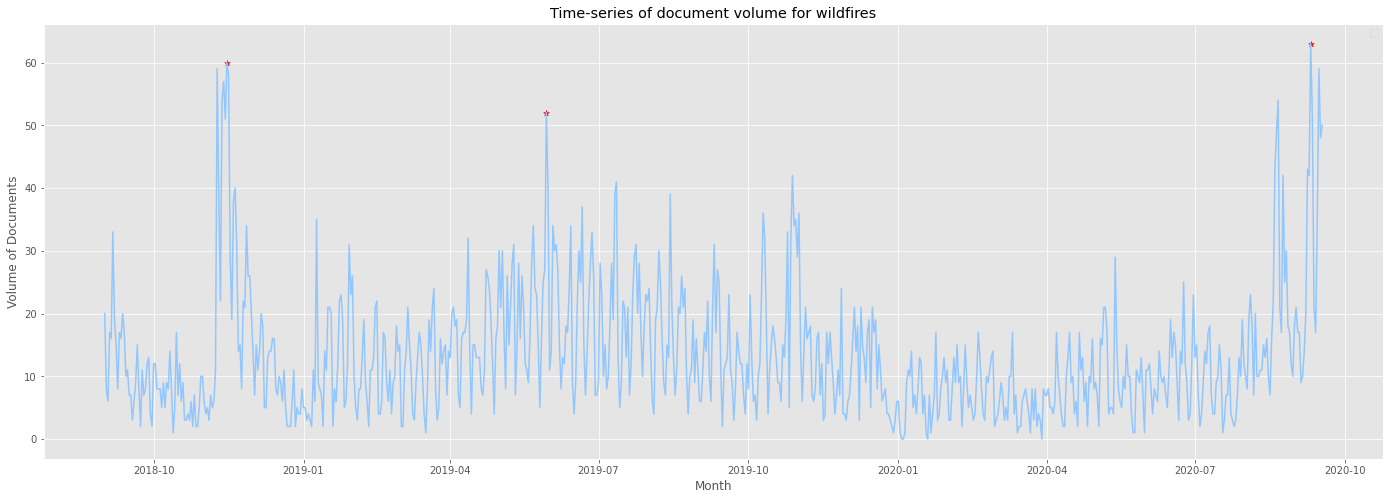

In [10]:
# find_peaks
peaks=news_class.find_peaks(document_count)


### Highlight Title based on Cosine Similarity

In [11]:
for date in peaks.index:
    peak=docs.loc[docs["date"]==date]
    index=news_class.highlight_title_embedding(peak)
    news_class.print_peak(index)

2018-11-15-----> Deadly Camp Fire sparks new lawsuit against California utility
2019-05-30-----> Homes reportedly destroyed by wildfire in northern Alberta Métis settlement
2020-09-10-----> Wildfire conditions complicate PG&E’s inspections during power shutoff


### Highlighting Title based on TFID

In [12]:
for date in peaks.index:
    peak=docs.loc[docs["date"]==date]
    index=news_class.highlight_title_tfid(peak)
    news_class.print_peak(index)

2018-11-15-----> WATCH: Northern California wildfire latest
2019-05-30-----> Wildfires force more people out of their homes in northern Alberta
2020-09-10-----> Over 1,000 homes lost as fires rage in Western states; Residents forced to flee in Oregon and California


### Highlighting Title Based on Term Frequency

In [13]:
for date in peaks.index:
    peak=docs.loc[docs["date"]==date]
    index=news_class.highlight_title_frequency(peak)
    news_class.print_peak(index)

2018-11-15-----> Camp Fire vs. Tubbs Fire: The two most destructive fires in California history
2019-05-30-----> Wildfires force more people out of their homes in northern Alberta
2020-09-10-----> Three dead as wildfire devastates  northern California


# Question 3

Question 3:
In my opinion, visualizations are great tools for human understanding and although it’s not the most sophisticated technique, it usually helps the most when humans try to understand complicated patterns and events. Therefore, I decided to create two visualizations. First, the most common topics in the corpus and their corresponding words. In order to do this, I did topic modeling using LDA and pyLDAvis for visualization.

Secondly, I thought that similar to question 2, users might be interested in understanding documents within a given date range. Therefore, I created a method that takes as inputs a start and end date. Then it shows important statistics about entities appearing in articles within those dates. That might help to understand if there were unusual people, organizations or locations named during that period. To be able to identify these rare cases, I plotted the distribution of the entities across articles for the entire dataset and the specified date range. Therefore, the user can see if some entities are very common on that date range but not in all the corpus.

Finally, I used the coordinates in the location entities to plot the frequency of documents by different locations. That way, the users can have a sense of where the events most likely happen.


### Show topics

In [14]:
news_class.topic_visualization(peak)

## Show stats for a given date range

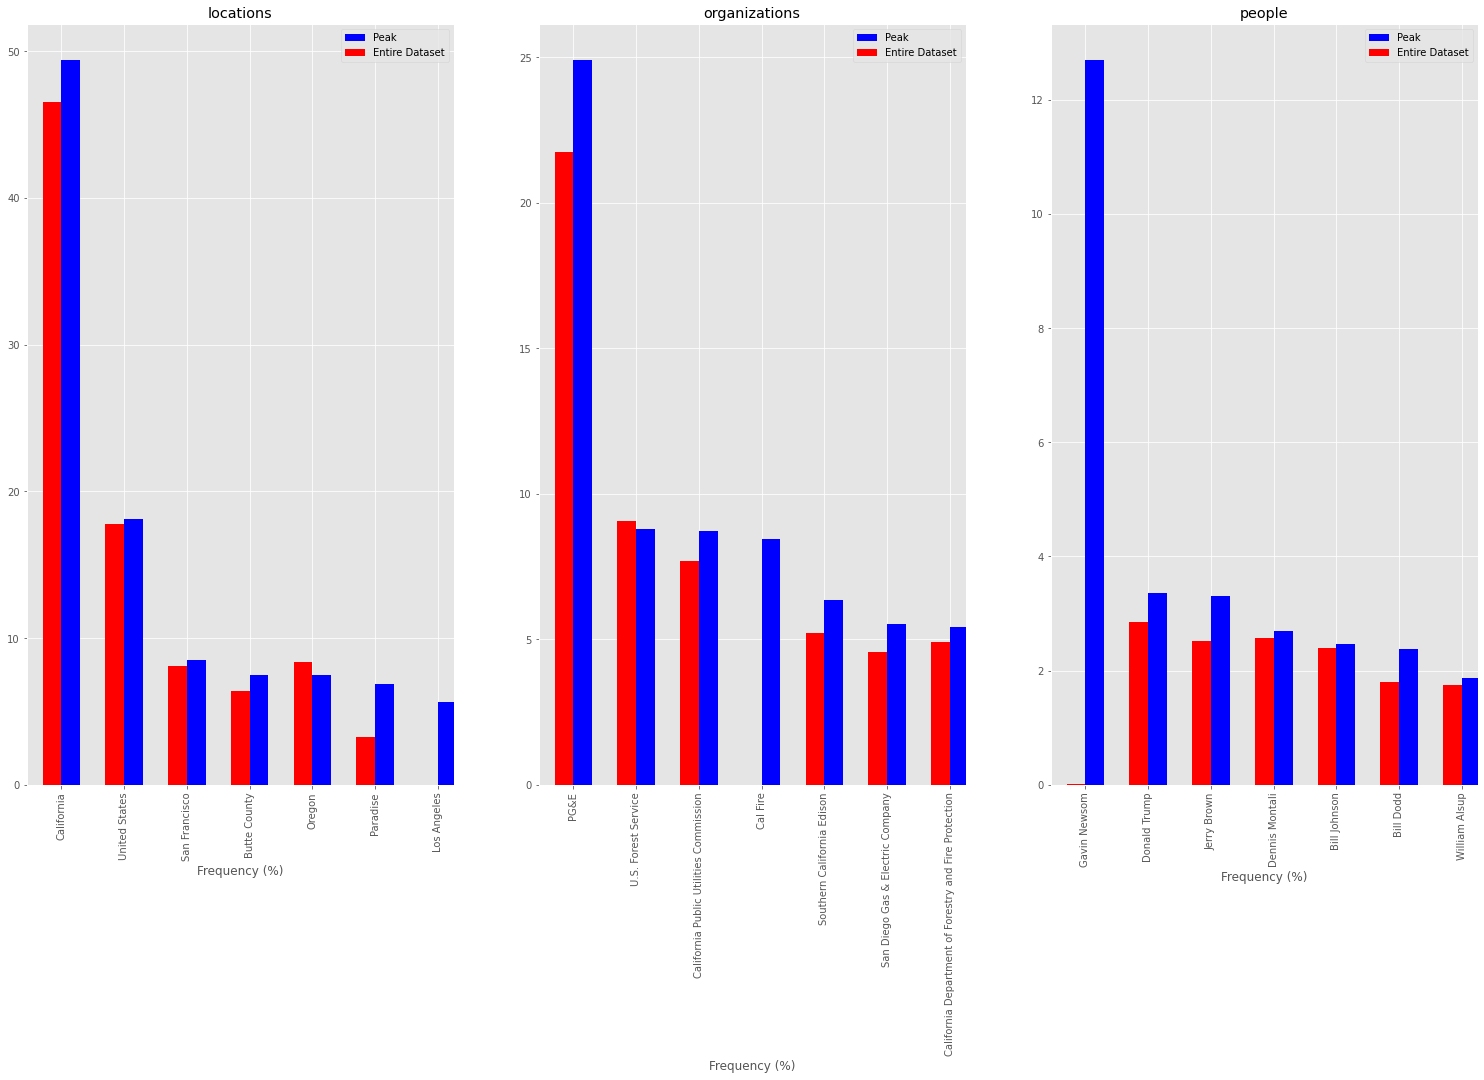

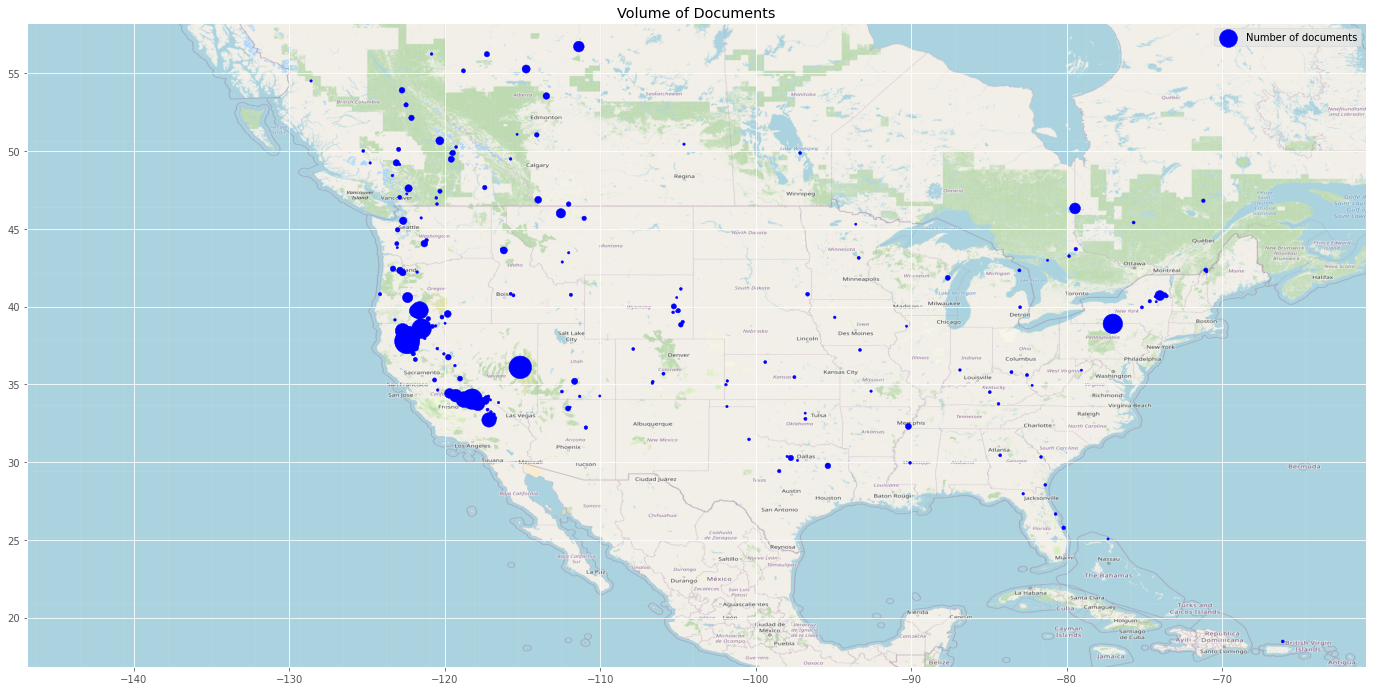

In [23]:
news_class.date_range_visualization("2016-01-30", "2020-02-15")